# Fokker-Planck basics

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from sys import path
path.insert(0, "lib")
import Fokker_Planck as fp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def simulate_sing(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right):
    """
    t: translation of the origin
    lr: learning rate
    dt: iterations per unit time
    time: total time simulated
    a: half distance between regular and singular minima
    nw: number of w points
    w_left, w_right: boundaries of the initial interval
    """
    
    b = 20
    steps = int(time/dt)
    v = ve = 1
    
    w, w0 = sym.symbols('w w0')
    # potential
    q = (w-t/2)**a
    # total length of the interval simulated
    L = t
    
    x, Ps = fp.run(q, nw, lr, v, ve, a, b, L, dt, steps, w_left, w_right, zero_prob_left, zero_prob_right)
    return q, x, Ps

In [6]:
lr = .05

time = 20
# singularity exponent
a = 2
x, P = dict(), dict()
ts = [4]
dts = [.1]
nws = [500]
zero_prob_left, zero_prob_right = True, False

xs, Ps = [], []
for t, nw, dt in zip(ts, nws, dts):
    w_left, w_right = -.5 + t/2, .5 + t/2
    
    q, x_tmp, P_tmp = simulate_sing(lr, dt, time, a, t, nw, w_left, w_right, zero_prob_left, zero_prob_right)
    xs.append(x_tmp)
    Ps.append(P_tmp)

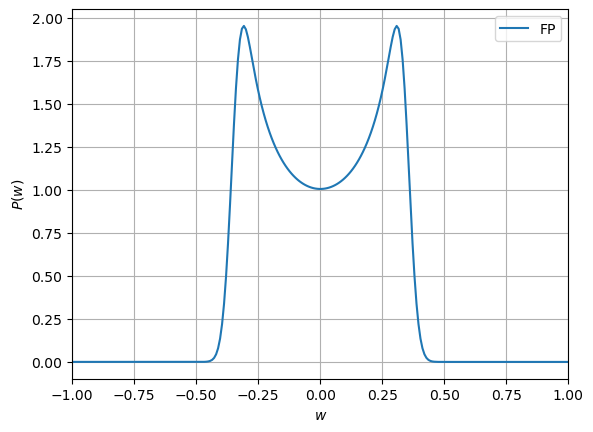

In [7]:
for t, x, P in zip(ts, xs, Ps):
    plt.plot(x-t/2, P[-1], label='FP')
plt.xlabel(r"$w$")
plt.ylabel(r"$P(w)$")
plt.grid()
plt.legend()
plt.xlim(-1,1)
plt.savefig("dynamics_1d_singular_model.png", bbox_inches="tight", dpi=150)
plt.show()